# Tully-Fisher Relation of galaxies in the Coma Cluster

Using the observations made as part of the Peculiar Velocity Survey, create the Tully-Fisher relation for those galaxies in the Coma Cluster.

In [1]:
import os

#from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
#from astropy.wcs import WCS
#from astropy.visualization.wcsaxes import SphericalCircle

#import psycopg2

import numpy as np

from scipy.optimize import minimize, curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Read in Coma cluster targets

Generated in the `PV_coma_targets` notebook

In [4]:
inComa_sga_table = Table.read('cache/tf_targets_coma_sga.fits', format='fits')

## Calculate the rotational velocities

And store those at $0.33R_{26}$

Also, remove those with a velocity > 5000 km/s

In [62]:
rmag = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(inComa_sga_table['SGA_ID'])):
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    targetid = sga_galaxy['TARGETID'][0]
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    idx, sep2d, sep3d = match_coordinates_sky(offcenter, center)
    r26 = 0.5 * float(sga_galaxy['D26'])
    sep_r26 = sep2d.to_value('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            rmag.append(float(sga_galaxy['R_MAG_SB26']))
            vmax.append(v033)
            dvmax.append(dv033)
    
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

50


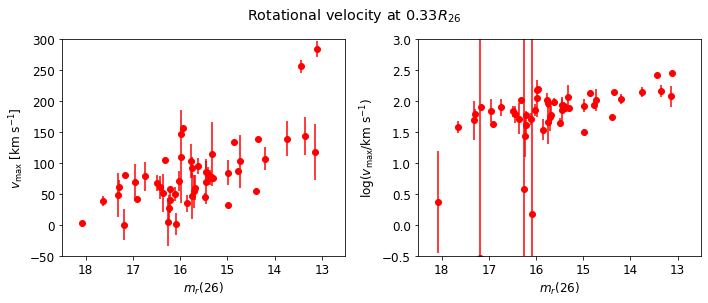

In [63]:
rmag = np.asarray(rmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

## Cuts on inclination angle and morphology

In [65]:
rmag_clean = []
vmax_clean = []
dvmax_clean = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))
inComa_sga_table['cosi'][np.isnan(inComa_sga_table['cosi'])] = 0 # Objects with b/a < 0.2

i = 0

for sga_id in np.unique(inComa_sga_table['SGA_ID']):
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    targetid = sga_galaxy['TARGETID'][0]
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    idx, sep2d, sep3d = match_coordinates_sky(offcenter, center)
    morphtype = sga_galaxy['MORPHTYPE'][0]
    cosi = sga_galaxy['cosi'][0]
    r26 = 0.5 * float(sga_galaxy['D26'])
    sep_r26 = sep2d.to_value('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        continue
        
    i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
        dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)

        rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
        vmax_clean.append(v033)
        dvmax_clean.append(dv033)
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()

<ipython-input-65-89f78b36dcee>:8: RuntimeWarning: invalid value encountered in sqrt
  inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))


## Fitting using `scipy.optimize.minimize`

Segev's code

In [69]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def fit_tfr(r, logv, dlogv):
    fmin = 1e99
    a, b = 6, -0.25
    
    succ_res = None
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(100):
        _a, _b = np.random.uniform(0,10), np.random.uniform(-1,0)
        
        res = minimize(l1norm, 
                       [_a, _b], 
                       args=(r, logv, dlogv),
                       method='L-BFGS-B', 
                       bounds=[[0,10], [-1,1]])
        
        if res.fun < fmin and res.success:
            print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
    
    if succ_res is None:
        print('No successful fits')
    else:
        print(succ_res)
    
    return a, b

Original
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 266.0302247344065, 'jac': array([  95.48430229, -966.75256584]), 'nfev': 603, 'njev': 201, 'nit': 25, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.02608442, -0.06182105]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
3.026084422974233 -0.06182105006846161

Cleaned
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 99.55141234895397, 'jac': array([ 34.9923797, -78.7243636]), 'nfev': 411, 'njev': 137, 'nit': 23, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.75185668, -0.10755527]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
3.7518566816135293 -0.1075552745646721


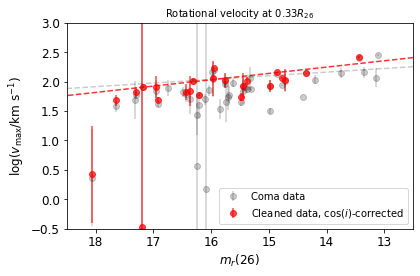

In [70]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
print('Original')

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.2,
            label='Coma data')

a, b = fit_tfr(rmag[isrmeas], log10vmax[isrmeas], dlog10vmax[isrmeas])
print(a, b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'k--', alpha=0.2)
################################################################################


################################################################################
# Cleaned data
#-------------------------------------------------------------------------------
print('\nCleaned')

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b = fit_tfr(rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])
print(a, b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

## Fitting using `scipy.optimize.curve_fit`

In [29]:
def line(x,m,b):
    '''
    y = mx + b
    '''
    return m*x + b

[0.02092375 1.77817072]
[-0.04834309  2.87017959]


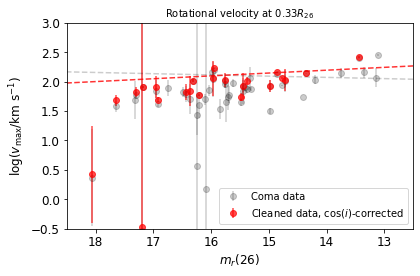

In [71]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.2,
            label='Coma data')

popt, pcov = curve_fit(line, 
                       rmag[isrmeas], 
                       log10vmax[isrmeas], 
                       p0=[-0.25, 6], 
                       sigma=dlog10vmax[isrmeas])
print(popt)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, line(r, *popt), 'k--', alpha=0.2)

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

popt, pcov = curve_fit(line, 
                       rmag_clean[isrmeas_clean], 
                       log10vmax_clean[isrmeas_clean], 
                       p0=[-0.25, 6],
                       sigma=dlog10vmax_clean[isrmeas_clean])
print(popt)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, line(r, *popt), 'r--', alpha=0.8)

ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))